# Table Segmentation Tool

This notebook is used to segment table regions from images.

**Usage:**
1. Run all cells sequentially
2. View the image with grid and coordinates
3. Input coordinate points manually
4. View segmentation results and binary mask

In [1]:
import sys
import os

# Add project paths to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'tracker'))
sys.path.insert(0, os.path.join(project_root, 'tracker', 'model'))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import torch

# Import SAM tools from the project
from tools.base_segmenter import BaseSegmenter

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.9.1+cu128
CUDA available: True


In [2]:
# Configuration
SAM_CHECKPOINT = '../checkpoints/sam_vit_h_4b8939.pth'  # SAM checkpoint path
MODEL_TYPE = 'vit_h'  # Model type: 'vit_b', 'vit_l', 'vit_h'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")
print(f"SAM checkpoint: {SAM_CHECKPOINT}")
print(f"Model type: {MODEL_TYPE}")

Device: cuda:0
SAM checkpoint: ../checkpoints/sam_vit_h_4b8939.pth
Model type: vit_h


In [3]:
# Initialize SAM segmenter
print("Loading SAM model...")
segmenter = BaseSegmenter(
    SAM_checkpoint=SAM_CHECKPOINT,
    model_type=MODEL_TYPE,
    device=DEVICE
)
print("SAM model loaded successfully!")

Loading SAM model...
Initializing BaseSegmenter to cuda:0
SAM model loaded successfully!


In [5]:
# Load image
IMAGE_PATH = '/home/zoyo/Downloads/desk.jpg'

# Read image
image = cv2.imread(IMAGE_PATH)
if image is None:
    print(f"Error: Cannot read image {IMAGE_PATH}")
    print("Please modify IMAGE_PATH to the correct path")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Image loaded successfully!")
    print(f"Image size: {image.shape[1]} x {image.shape[0]} (width x height)")
    
    # Set image to SAM
    segmenter.set_image(image)
    print("Image set to SAM model")

Image loaded successfully!
Image size: 461 x 339 (width x height)
Image set to SAM model



Displaying image with grid...
Please note the coordinates of the table area.
You'll input these coordinates in the next cell.



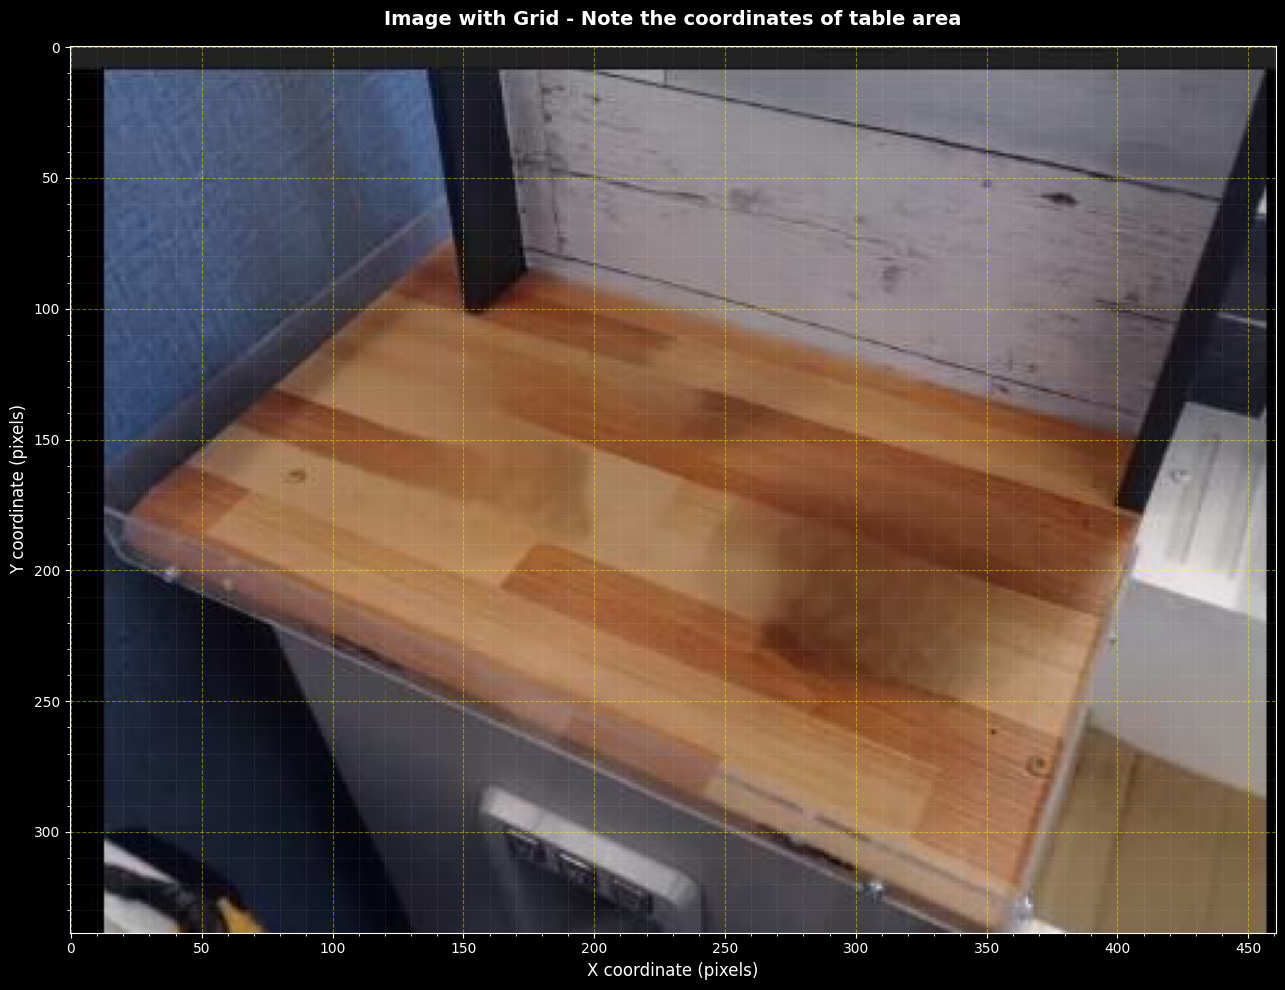

In [7]:
# Display image with grid and coordinates
def show_image_with_grid(image, grid_size=50):
    """Display image with grid and coordinate system"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Display image
    ax.imshow(image)
    
    # Add grid
    h, w = image.shape[:2]
    ax.set_xticks(np.arange(0, w, grid_size))
    ax.set_yticks(np.arange(0, h, grid_size))
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='yellow')
    
    # Set title and labels
    ax.set_title('Image with Grid - Note the coordinates of table area', 
                fontsize=14, pad=15, weight='bold')
    ax.set_xlabel('X coordinate (pixels)', fontsize=12)
    ax.set_ylabel('Y coordinate (pixels)', fontsize=12)
    
    # Enable minor ticks for finer reference
    ax.set_xticks(np.arange(0, w, grid_size//5), minor=True)
    ax.set_yticks(np.arange(0, h, grid_size//5), minor=True)
    ax.grid(which='minor', alpha=0.2, linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

if 'image' in locals() and image is not None:
    print("\nDisplaying image with grid...")
    print("Please note the coordinates of the table area.")
    print("You'll input these coordinates in the next cell.\n")
    show_image_with_grid(image, grid_size=50)
else:
    print("Please load an image first!")

Input points:
  Point 1: [230, 170] - Positive (table)
  Point 2: [150, 120] - Positive (table)
  Point 3: [310, 210] - Positive (table)


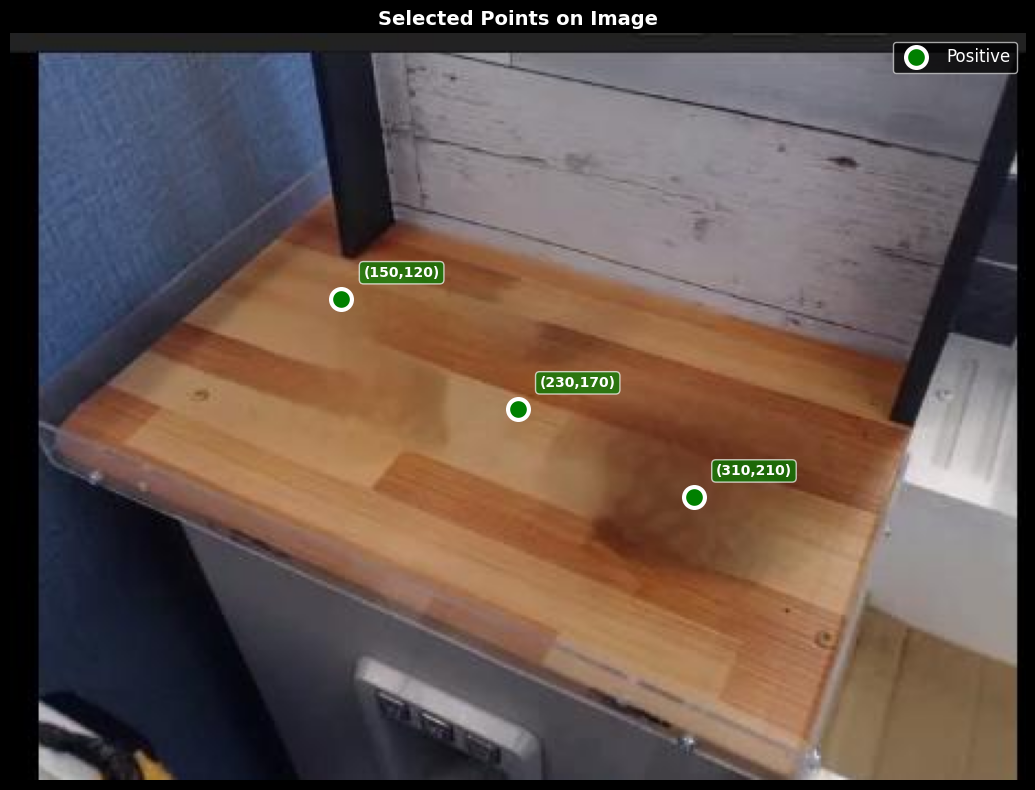


Points visualization complete. Run next cell to perform segmentation.


In [8]:
# Input coordinate points manually
# Format: [[x1, y1], [x2, y2], ...]
# Labels: 1 = positive (table area), 0 = negative (background)

# Example: Click 3 points on the table
points = [
    [230, 170],  # Point 1: center of table
    [150, 120],  # Point 2: left side of table
    [310, 210],  # Point 3: right side of table
]

# Labels for each point (1 = positive, 0 = negative)
labels = [
    1,  # Point 1 is positive (on table)
    1,  # Point 2 is positive (on table)
    1,  # Point 3 is positive (on table)
]

print("Input points:")
for i, (point, label) in enumerate(zip(points, labels)):
    label_text = "Positive (table)" if label == 1 else "Negative (background)"
    print(f"  Point {i+1}: {point} - {label_text}")

# Visualize the input points on the image
if 'image' in locals() and image is not None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    
    # Plot points
    for point, label in zip(points, labels):
        color = 'green' if label == 1 else 'red'
        marker_label = 'Positive' if label == 1 else 'Negative'
        ax.plot(point[0], point[1], 'o', color=color, markersize=15, 
               markeredgewidth=3, markeredgecolor='white', label=marker_label)
        ax.text(point[0]+10, point[1]-10, f'({point[0]},{point[1]})', 
               color='white', fontsize=10, weight='bold',
               bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
    
    # Remove duplicate labels
    handles, labels_legend = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_legend, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=12)
    
    ax.set_title('Selected Points on Image', fontsize=14, weight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("\nPoints visualization complete. Run next cell to perform segmentation.")

In [9]:
# Perform segmentation
def segment_table(segmenter, points, labels, multimask=True):
    """Segment table using input points"""
    if len(points) == 0:
        print("Error: Please input at least one point!")
        return None, None, None
    
    print(f"\nSegmenting with {len(points)} points...")
    
    # Prepare input
    point_coords = np.array(points)
    point_labels = np.array(labels)
    
    prompts = {
        'point_coords': point_coords,
        'point_labels': point_labels,
    }
    
    # Perform prediction
    masks, scores, logits = segmenter.predict(prompts, 'point', multimask=multimask)
    
    # Select mask with highest score
    best_idx = np.argmax(scores)
    mask = masks[best_idx]
    score = scores[best_idx]
    
    print(f"Segmentation complete! Score: {score:.4f}")
    print(f"Mask area: {mask.sum()} / {mask.size} pixels ({100*mask.sum()/mask.size:.2f}%)")
    
    return mask, scores, logits

# Execute segmentation
if 'points' in locals() and 'labels' in locals() and 'image' in locals():
    mask, scores, logits = segment_table(segmenter, points, labels, multimask=True)
    
    if mask is not None:
        print("\n✓ Segmentation successful!")
        print("Run next cell to visualize results.")
else:
    print("Please complete previous cells first!")


Segmenting with 3 points...
Segmentation complete! Score: 0.9938
Mask area: 56995 / 156279 pixels (36.47%)

✓ Segmentation successful!
Run next cell to visualize results.


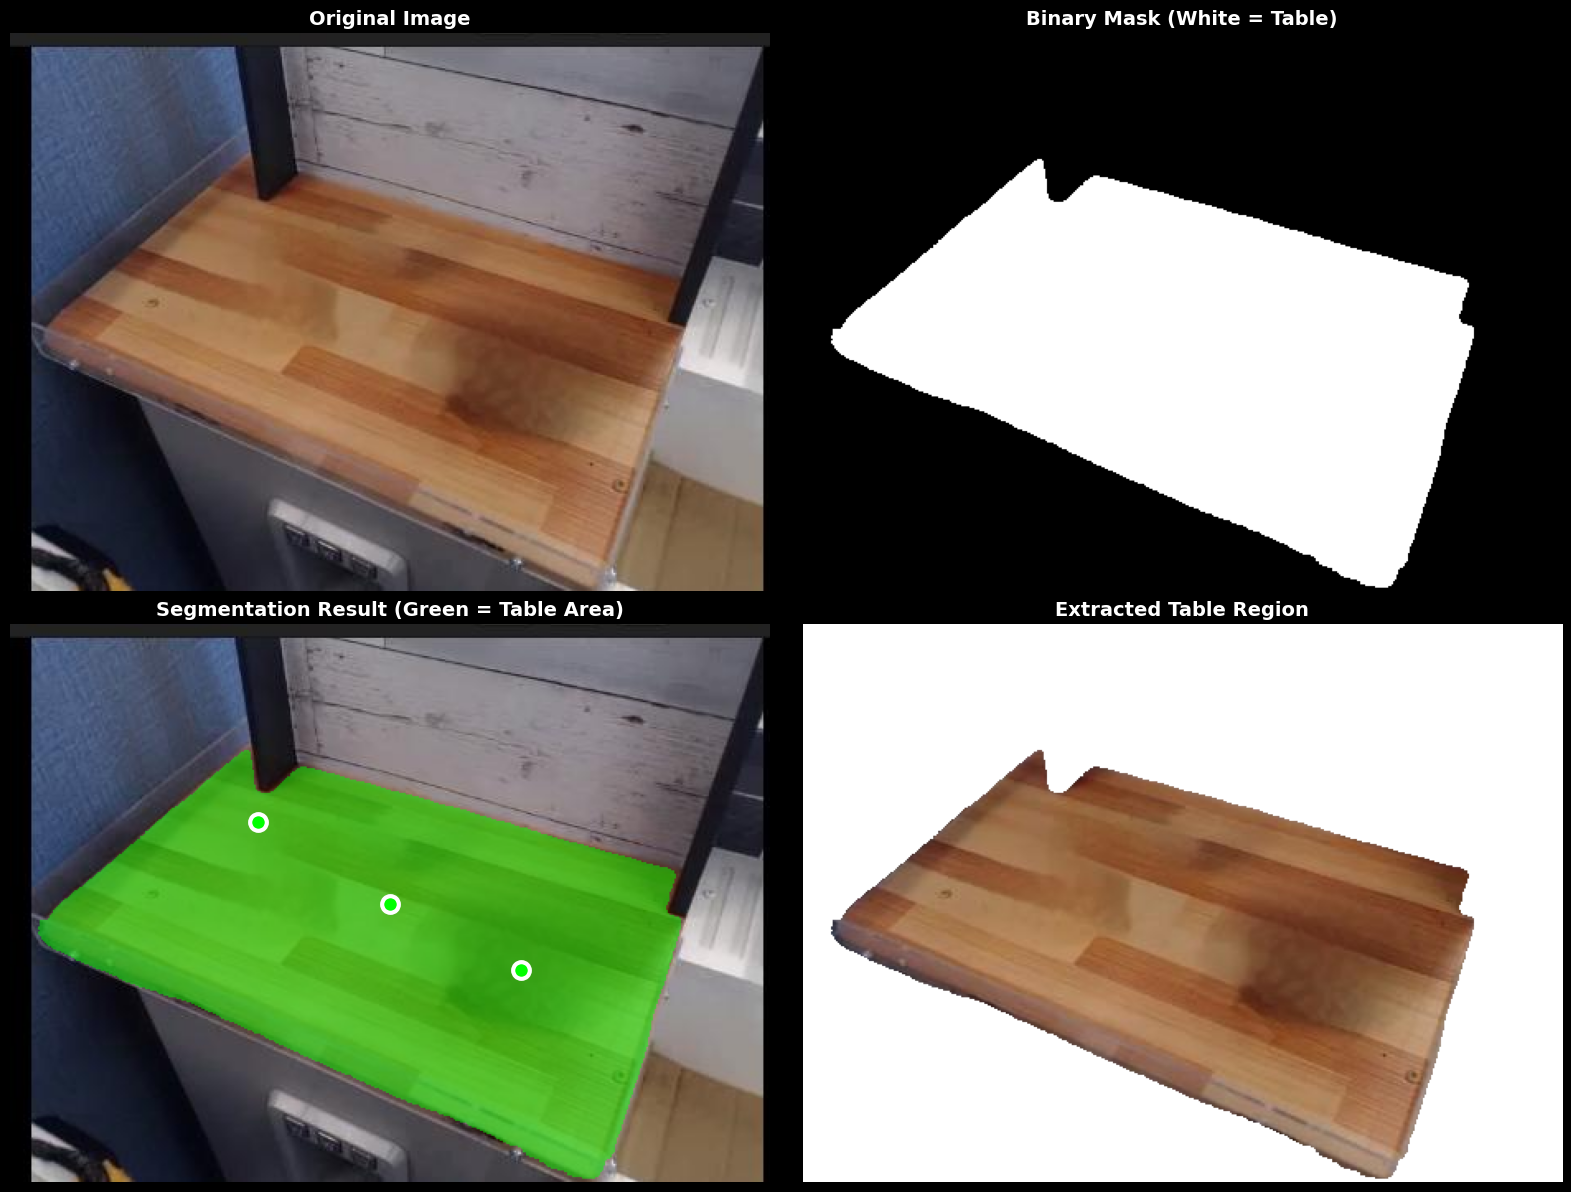


SEGMENTATION SUMMARY
Number of points: 3
Point coordinates: [[230, 170], [150, 120], [310, 210]]
Point labels: [1, 1, 1] (1=positive, 0=negative)
Mask coverage: 36.47% of image


In [10]:
# Visualize results
if 'mask' in locals() and mask is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontsize=14, weight='bold')
    axes[0, 0].axis('off')
    
    # 2. Binary mask
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Binary Mask (White = Table)', fontsize=14, weight='bold')
    axes[0, 1].axis('off')
    
    # 3. Mask overlay
    overlay = image.copy()
    overlay[mask > 0] = overlay[mask > 0] * 0.5 + np.array([0, 255, 0]) * 0.5
    axes[1, 0].imshow(overlay.astype(np.uint8))
    
    # Mark input points
    for point, label in zip(points, labels):
        color = 'lime' if label == 1 else 'red'
        axes[1, 0].plot(point[0], point[1], 'o', color=color, markersize=12, 
                       markeredgewidth=3, markeredgecolor='white')
    
    axes[1, 0].set_title('Segmentation Result (Green = Table Area)', fontsize=14, weight='bold')
    axes[1, 0].axis('off')
    
    # 4. Extracted table region only
    table_only = image.copy()
    table_only[mask == 0] = 255  # White background
    axes[1, 1].imshow(table_only)
    axes[1, 1].set_title('Extracted Table Region', fontsize=14, weight='bold')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("SEGMENTATION SUMMARY")
    print("="*60)
    print(f"Number of points: {len(points)}")
    print(f"Point coordinates: {points}")
    print(f"Point labels: {labels} (1=positive, 0=negative)")
    print(f"Mask coverage: {100*mask.sum()/mask.size:.2f}% of image")
    print("="*60)
else:
    print("Please run the segmentation cell first!")

In [11]:
# Save results
if 'mask' in locals() and mask is not None:
    output_dir = './output'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save binary mask
    mask_uint8 = (mask * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(output_dir, 'table_mask.png'), mask_uint8)
    
    # Save overlay
    overlay_bgr = cv2.cvtColor(overlay.astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, 'table_overlay.png'), overlay_bgr)
    
    # Save extracted table region
    table_only_bgr = cv2.cvtColor(table_only, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, 'table_extracted.png'), table_only_bgr)
    
    # Save mask as numpy array
    np.save(os.path.join(output_dir, 'table_mask.npy'), mask)
    
    print(f"\n✓ Results saved to {output_dir}/ directory:")
    print("  - table_mask.png: Binary mask image")
    print("  - table_mask.npy: Mask numpy array")
    print("  - table_overlay.png: Mask overlay on original image")
    print("  - table_extracted.png: Extracted table region")
    print("\nAll files saved successfully!")
else:
    print("No results to save. Please run segmentation first!")


✓ Results saved to ./output/ directory:
  - table_mask.png: Binary mask image
  - table_mask.npy: Mask numpy array
  - table_overlay.png: Mask overlay on original image
  - table_extracted.png: Extracted table region

All files saved successfully!


In [ ]:
# Reset and start over (if you want to select different points)
if 'image' in locals():
    # Reset image in segmenter
    segmenter.reset_image()
    segmenter.set_image(image)
    print("✓ Reset complete!")
    print("To segment again:")
    print("  1. Go back to the cell where you input points")
    print("  2. Modify the 'points' and 'labels' variables")
    print("  3. Re-run cells from there onwards")

## Usage Instructions

### Steps:
1. **Modify image path**: Change `IMAGE_PATH` in cell 4
2. **Run all cells sequentially**: Execute cells in order
3. **View image with grid**: Note the coordinates of the table area
4. **Input points**: In cell 6, modify the `points` and `labels` lists
   - `points`: List of [x, y] coordinates
   - `labels`: 1 for positive (table), 0 for negative (background)
   - Recommend 2-5 points on the table
5. **Run segmentation**: Execute cell 7 to perform segmentation
6. **View results**: Cell 8 shows visualization
7. **Save results**: Cell 9 saves outputs to `output/` directory

### Tips:
- Add more positive points (label=1) on different parts of the table for better accuracy
- Add negative points (label=0) if unwanted regions are included
- Use the grid to accurately determine point coordinates
- If result is not satisfactory, run the reset cell and modify points

### Example Points:
```python
# Example 1: Simple - 3 points on table
points = [[200, 150], [300, 200], [250, 180]]
labels = [1, 1, 1]

# Example 2: With negative point to exclude background
points = [[200, 150], [300, 200], [250, 180], [50, 50]]
labels = [1, 1, 1, 0]  # Last point is negative
```

### Output Files:
- **table_mask.png**: Binary mask (white=table, black=background)
- **table_mask.npy**: Numpy array for further processing
- **table_overlay.png**: Green highlight showing segmented area
- **table_extracted.png**: Table region on white background

### Technical Details:
- **Model**: Segment Anything Model (SAM)
- **Input**: Point coordinates + labels
- **Output**: Binary mask (numpy array, shape: [H, W])
- **Mask values**: True/1 = table, False/0 = background